# Банки — Анализ оттока клиентов

### Цель проекта

Для регионального банка "Метанпромбанк" выделить от компактные однородные сегменты клиентов, которые склонны уходить из банка. Дать примеры мероприятий, позволяющих удержать сомневающихся клиентов от оттока.

### Заказчик

Менеджер из отдела маркетинга

### Описание проекта

- Провести исследовательский анализ данных, определить все значимые
признаки отточности (интервалы значений характеристик, которые связаны с
повышенным оттоком, сравните портреты типичных клиентов, которые
склонны и не склонны уходить из банка и т.д)
- Сформулировать и проверить статистические гипотезы.

*Проверить гипотезу различия дохода между теми клиентами, которые
ушли и теми, которые остались*

*Проверить гипотезу различия в количестве банковских продуктов для оставшихся и отточных клиентов*(предварительно)

- Объединяя признаки отточности, сформировать сегменты, отберать из них 3-5
лучших и дать по ним рекомендации

### Описание данных

/datasets/bank_scrooge.csv

Датасет содержит данные о клиентах банка «Метанпром». Банк располагается в
Ярославле и областных городах: Ростов Великий и Рыбинск.

Колонки:

`USERID` — идентификатор пользователя,который является клиентом банка на текущий момент

`score` — баллы кредитного скоринга без разбивки на рейтинги

`city` — город

`gender` — пол

`age` — возраст

`equity` — количество баллов собственности(чем выше показатель, тем состоятельнее клиент)

`balance` — баланс на счёте на момент выгрузки

`products` — количество продуктов, которыми пользуется клиент

`credit_card` — есть ли кредитная карта

`last_activity` — активный клиент(оцениваем за последние 3 месяца)

`EST_SALARY` — оценочный доход клиента(любой доход, оценивается раз в 3 месяца)

`сhurn` — признак оттока(подписан договор или пройден опрос в приложении)


По итогам исследования подготовить презентацию в формате pdf, прикрепив ссылку на файл в основном
проекте.

### План работы (декомпозиция)

[**1. Загрузка данных**](#start)

[**2. Предобработка данных**](#preprocessing)

- Привести названия столбцов к змеиному регистру
- Проверить пропуски, исследовать их природу.Заполнить, при необходимости
- Проверить типы данных. Откорректировать, если нужно
- Проверить наличие явных и неявных дубликатов
- Оценить выбросы и корректность данных
- Кодировать категориальные переменные для столбца "gender" и "city"

[**3. Исследовательский анализ данных**](#analysis)

- Сравнение портретов типичных клиентов(средние и медианы для отточных и остающихся клиентов)
- Оценить непрерывные признаки, посмотрев графики распределения как для отточных, так и для неотточных клиентов
- Оценить уровни оттока для категориальных переменных(столбчатые диаграммы или тепловые карты) 
- Выделение значимых признаков отточности методом корреляции
- Анализ каждого выбранного признака

[**4. Проверка статистических гипотез**](#stat)

- Проверить гипотезу различия дохода между теми клиентами, которые ушли и теми, которые остались

- Проверить гипотезу различия доли отточных клиентов между городами Ярославль и Ростов

[**5. Сегментация и приоритизация клиентов**](#segment) 

в зависимости от доли их отточности(суммарная доля всех сегментрованных пользователей должна быть выше 35% от общего числа отточных клиентов)

[**6. Рекомендации для отдела маркетинга**](#rec)

[**7. Подготовка презентации**](#presentation)

### 1. Загрузка данных <a id="start"></a> 

In [1]:
pip install phik --quiet

Note: you may need to restart the kernel to use updated packages.


In [2]:
# загрузка библиотек

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math as mth
import datetime as dt
from scipy import stats as st
import missingno as msno
import phik
from phik.report import plot_correlation_matrix
import warnings
warnings.filterwarnings("ignore")

In [3]:
# чтение файла csv и сохранение в df и разделим данные на столбцы
try:
    df = pd.read_csv('/Users/irinakuzina/Downloads/bank_scrooge.csv')
except:
    df = pd.read_csv('/datasets/bank_scrooge.csv')

In [4]:
# Получения первичной информации о датафрейме

def describe (data):
    print('---------Первые 10 строк-----------')
    display(data.head(10))
    print('---------Типы данных---------------\n')
    display(data.info())
    print('---------Статистическая сводка---------------')
    display(data.describe())
    print('---------Пропуски-----------\n')
    display(data.isna().sum())
    print('\n---------Процент пропусков от всего датасета-----------')
    display(
        data.isna().mean().sort_values(ascending=False)*100)
    print('\n---------Дубликаты-----------\n')
    if data.duplicated().sum() > 0:
        print('Дубликатов: ', data.duplicated().sum())
    else:
        print('Дубликатов НЕТ')

In [5]:
describe(df)

---------Первые 10 строк-----------


,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1
5,202305,856.0,Рыбинск,М,56.0,4,863687.24,3,1,0,156619.80,0
6,177259,807.0,Ярославль,Ж,39.0,3,405042.44,3,0,1,103838.32,0
7,218868,825.0,Ярославль,Ж,38.0,4,458145.40,2,1,1,68085.48,0
8,211686,923.0,Ярославль,М,54.0,5,1206337.87,2,1,0,155371.79,0
9,133130,906.0,Ярославль,Ж,67.0,0,NaN,1,0,1,238055.53,0


---------Типы данных---------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


None

---------Статистическая сводка---------------


,USERID,score,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
count,10000.00000,10000.000000,9974.000000,10000.000000,7.705000e+03,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000
mean,171814.71260,848.699400,42.734409,2.627600,8.277943e+05,1.870100,0.680400,0.523500,1.478669e+05,0.182000
std,33708.23812,65.448519,12.179971,1.980836,1.980614e+06,0.792647,0.466345,0.499472,1.393885e+05,0.385864
min,94561.00000,642.000000,18.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,2.546300e+03,0.000000
25%,142810.25000,802.000000,33.000000,0.000000,2.955542e+05,1.000000,0.000000,0.000000,7.525190e+04,0.000000
50%,172728.00000,853.000000,40.000000,3.000000,5.242722e+05,2.000000,1.000000,1.000000,1.196581e+05,0.000000
75%,201261.75000,900.000000,51.000000,4.000000,9.807058e+05,2.000000,1.000000,1.000000,1.745005e+05,0.000000
max,229145.00000,1000.000000,86.000000,9.000000,1.191136e+08,5.000000,1.000000,1.000000,1.395064e+06,1.000000


---------Пропуски-----------



USERID              0
score               0
city                0
gender              0
age                26
equity              0
balance          2295
products            0
credit_card         0
last_activity       0
EST_SALARY          0
churn               0
dtype: int64


---------Процент пропусков от всего датасета-----------


balance          22.95
age               0.26
USERID            0.00
score             0.00
city              0.00
gender            0.00
equity            0.00
products          0.00
credit_card       0.00
last_activity     0.00
EST_SALARY        0.00
churn             0.00
dtype: float64


---------Дубликаты-----------

Дубликатов НЕТ


**Вывод по разделу "Загрузка данных"**:
- Всего 10000 строк в датасете
- Аномалии в стобце "Products" - 0 значения. В дф представлена только актуальная клиентская база, значит как минимум 1 продукт должен быть
- Пропусков в столбцах "age" и "balance"
- Полных дубликтов нет
- Проверить данные на неявные дубликаты
- Необходимо переименовать столбцы и привести к змеиному регистру
- Изменить типа данных в столбце "score" и "age" и привести к типу int64
- Кодировать категориальные переменные для столбца "gender" и "city"

### 2. Предобработка данных <a id="preprocessing"></a> 

In [6]:
#Приведем название столбцов к змениному регистру
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.columns

Index(['userid', 'score', 'city', 'gender', 'age', 'equity', 'balance',
       'products', 'credit_card', 'last_activity', 'est_salary', 'churn'],
      dtype='object')

In [7]:
#Изменим типа данных в столбце "score" на тип int64
df['score'] = df['score'].astype('int')
df.dtypes

userid             int64
score              int64
city              object
gender            object
age              float64
equity             int64
balance          float64
products           int64
credit_card        int64
last_activity      int64
est_salary       float64
churn              int64
dtype: object

In [8]:
#Посмотрим сколько клиентов имеют 0 значения в столбце "products"
display(len(df.query('products==0')))

1

Так как для анализа нам нужны еще актуальные клиенты банка, которые только собираются уйти, то эту строку необходимо удалить

In [9]:
#Исключаем из списка пользователя с 0 продуктом
df = df.query('products!=0')
df['products'].describe()

count    9999.000000
mean        1.870287
std         0.792466
min         1.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         5.000000
Name: products, dtype: float64

In [10]:
#Проверим данные на неявные дубликаты по столбцам
display(df['userid'].duplicated().sum())
display(df[df['userid'].duplicated()])

73

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
1583,190253,726,Ярославль,М,49.0,0,NaN,1,1,1,177700.78,0
1837,210662,896,Рыбинск,Ж,37.0,0,NaN,2,0,0,90916.04,0
2138,131419,739,Рыбинск,Ж,37.0,3,1307941.65,3,0,0,103867.47,0
2165,187635,692,Рыбинск,Ж,NaN,0,NaN,1,1,1,160368.82,0
2302,220816,934,Рыбинск,Ж,74.0,5,1294285.39,3,1,0,95606.80,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9775,124450,758,Рыбинск,Ж,36.0,0,73574.07,2,0,1,79963.59,0
9785,168998,895,Рыбинск,М,44.0,0,282653.53,3,0,0,255296.47,0
9819,140934,832,Рыбинск,Ж,NaN,3,385763.16,2,0,1,59651.35,0
9880,217412,886,Ярославль,Ж,35.0,3,1026172.14,2,1,0,53099.16,0


У нас 73 задублированных userid, необходимо это проверить

In [11]:
#Выберем несколько 'userid' 
display(df.query('userid==190253'))
display(df.query('userid==124450'))
display(df.query('userid==175730'))

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
231,190253,823,Рыбинск,М,37.0,4,373348.39,2,0,1,131947.92,1
1583,190253,726,Ярославль,М,49.0,0,NaN,1,1,1,177700.78,0


,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
8164,124450,859,Ярославль,Ж,38.0,6,516811.20,1,1,1,95144.63,1
9775,124450,758,Рыбинск,Ж,36.0,0,73574.07,2,0,1,79963.59,0


,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
7753,175730,846,Ярославль,Ж,32.0,7,216764.74,4,1,1,77100.85,1
9970,175730,816,Рыбинск,М,36.0,4,477892.07,3,1,0,81100.60,0


Проверка показала, что дубли по 'userid' предположительно не имеют связи с городам. Необходимо это подтвердить

In [12]:
#Проверим неявные дубликаты для пары "userid - city"

df.duplicated(subset=['userid','city']).sum()

0

В банке видимо можно присваивать одинаковый userid для клиентов из разных городов,поэтому это разные клиенты. Можно изменть 'userid' дубликатов, чтобы точно их убрать

In [13]:
#Добавим 00 к дублированным значениям
df.loc[df['userid'].duplicated(),'userid']*=100
#Проверяем
display(df['userid'].duplicated().sum())

0

In [14]:
#Проверяем неявные дубликаты для столбца city и gender	
display(df['city'].unique())
display(df['gender'].unique())

array(['Рыбинск', 'Ярославль', 'Ростов'], dtype=object)

array(['Ж', 'М'], dtype=object)

Неявных дубликатов нет

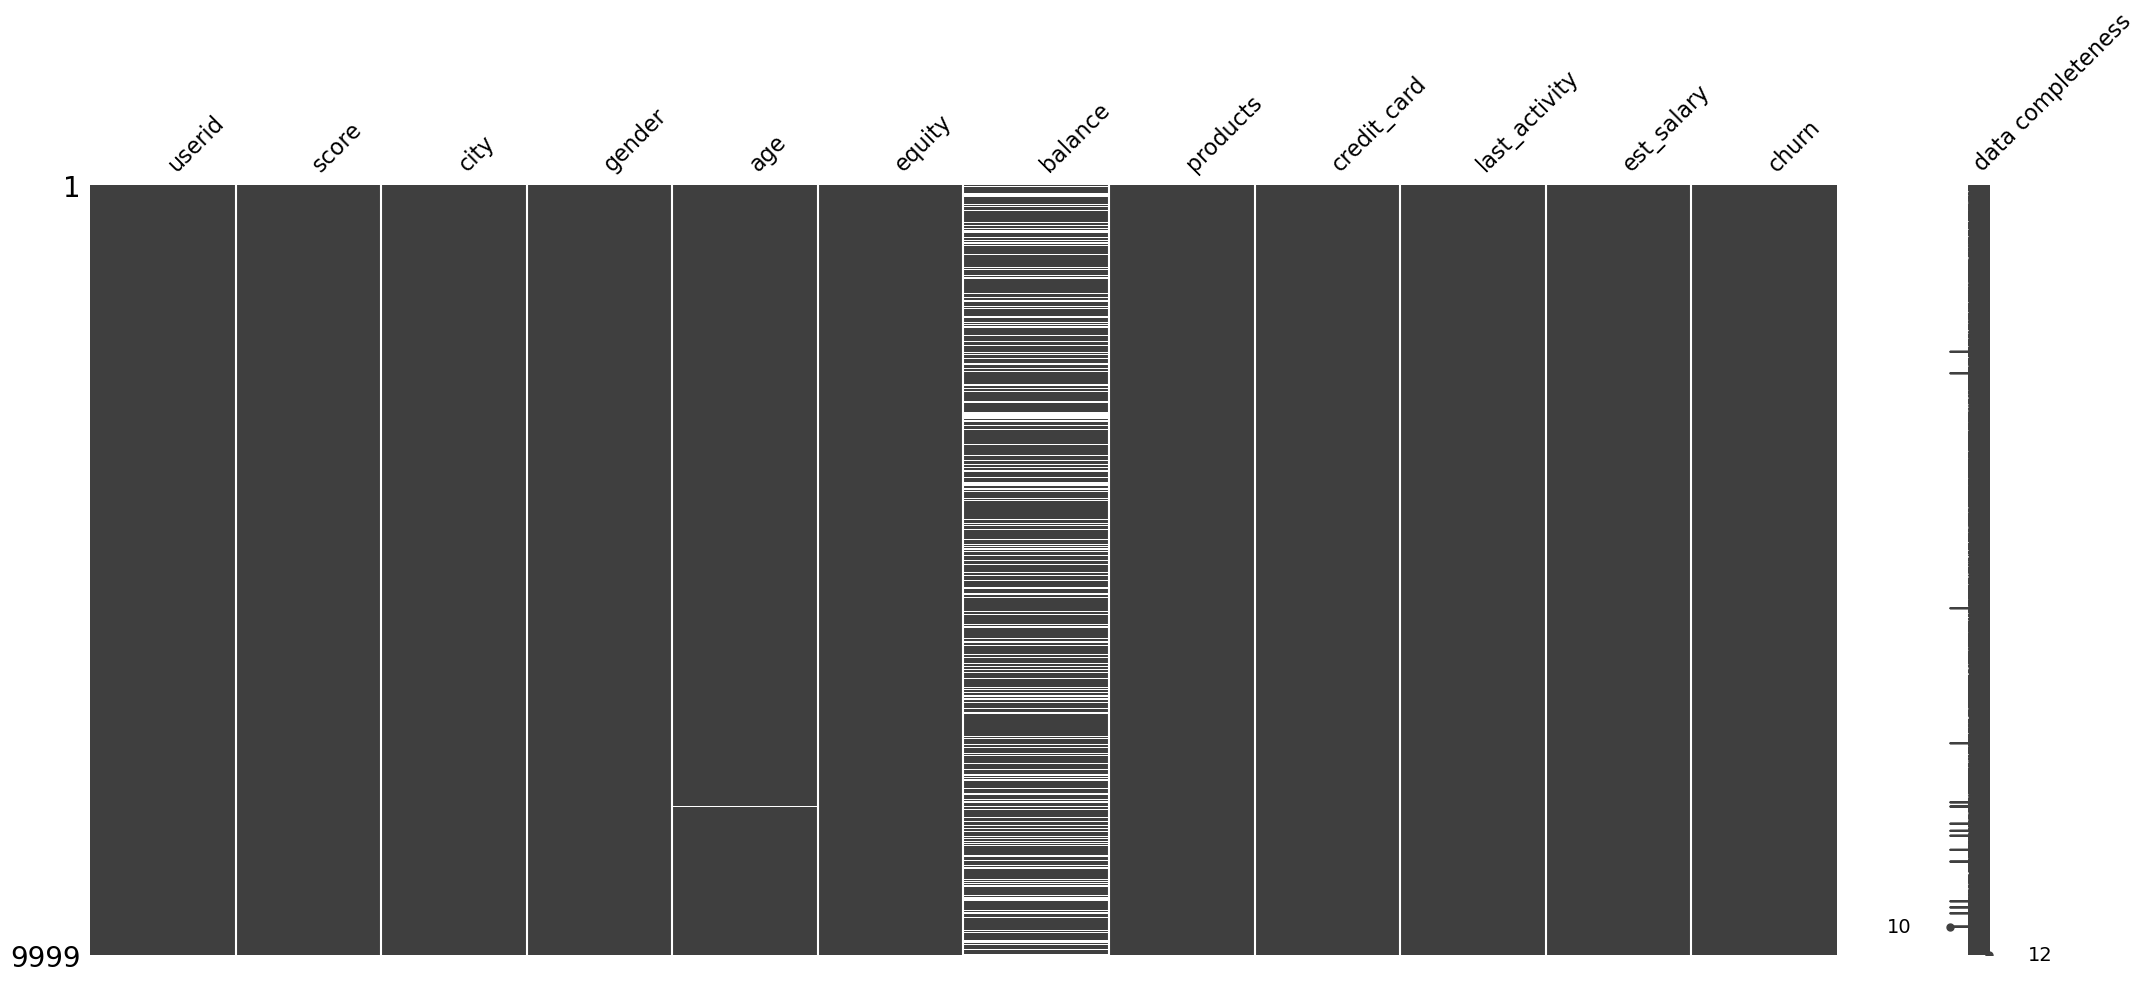

In [15]:
#Исследуем пропуски в df
msno.matrix(df, labels=True)
plt.show()

Пропуски в df распределны хаотично без каких-либо закономерностей

In [16]:
#Обработаем пропуски в столбце age
display(df['age'].isna().sum())
display(df['age'].isna().mean()*100)

26

0.26002600260026004

Пропусков меньше процента в этом столбце. Проверим, есть ли отточные клиенты с пропусками по возрасту

In [17]:
#Наличие отточные клиентов с пропусками в столбце age
len(df[(df['churn'] ==1) & (df['age'].isna())])

1

1 отточный клиент с пропуском по возрасту. Пропуски в столбце age относятся к MCAR (Missing Completely At Random / Отсутствует совершенно случайно) — пропуски не зависят от переменных и не ведут к систематической ошибке (смещение, bias), но увеличивают случайную ошибку (разброс, variance), можно их отбрасывать или заполнять, т.к. заполнение не повлияет на характер связи между заполняемой переменной и остальными.Данными можно пренебречь и удалить эти пропуски

In [18]:
df = df.dropna(subset=['age'])
df['age'].isna().sum()

0

In [19]:
#Сразу изменим тип данных в столбце age после удаления пропусков на int64
df['age'] = df['age'].astype('int')
df.dtypes

userid             int64
score              int64
city              object
gender            object
age                int64
equity             int64
balance          float64
products           int64
credit_card        int64
last_activity      int64
est_salary       float64
churn              int64
dtype: object

In [20]:
#Обработаем пропуски в столбце balance
display(df['balance'].isna().sum())
display(round(df['balance'].isna().mean()*100,1))

2278

22.8

23% данных пропущено, чтобы принять решение о дальнейшей обработке пропусков, необходимо исследовать взаимосвязь balance с другими данными.

In [21]:
#Закодируем данные balance и создадим столбец с бинарными значениями, где 1-есть пропуск, 0-нет
#Создадим датафрейм для корреляции признаков
bank = df.copy()
bank['balance_new'] = bank['balance'].apply(lambda x:1 if pd.isna(x) else 0)
#Удалим столбец 'balance', чтобы он мешал при расчете корреляции
bank = bank.drop('balance', axis =1)
bank.head(10)

,userid,score,city,gender,age,equity,products,credit_card,last_activity,est_salary,churn,balance_new
0,183012,850,Рыбинск,Ж,25,1,2,0,1,75719.14,1,0
1,146556,861,Рыбинск,Ж,37,5,3,1,0,86621.77,0,0
2,120722,892,Рыбинск,Ж,30,0,1,1,1,107683.34,0,1
3,225363,866,Ярославль,Ж,51,5,2,0,1,174423.53,1,0
4,157978,730,Ярославль,М,34,5,1,1,0,67353.16,1,0
5,202305,856,Рыбинск,М,56,4,3,1,0,156619.80,0,0
6,177259,807,Ярославль,Ж,39,3,3,0,1,103838.32,0,0
7,218868,825,Ярославль,Ж,38,4,2,1,1,68085.48,0,0
8,211686,923,Ярославль,М,54,5,2,1,0,155371.79,0,0
9,133130,906,Ярославль,Ж,67,0,1,0,1,238055.53,0,1


In [22]:
#Для расчета корреляции будем использовать библиотеку phik
#Она сразу работает со всеми признаками, считая нужный тип корреляции в зависимости от принадлежности признака к той или иной категории
#параметр interval_cols содержит список непрерывных признаков(score,age,est_salary)
phik_bank = bank.phik_matrix(interval_cols= ['score','age','est_salary',]).round(2)
phik_bank

,userid,score,city,gender,age,equity,products,credit_card,last_activity,est_salary,churn,balance_new
userid,1.0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
score,1.0,1.00,0.09,0.07,0.03,0.53,0.42,0.21,0.05,0.40,0.23,0.75
city,1.0,0.09,1.00,0.01,0.09,0.06,0.13,0.07,0.03,0.17,0.02,0.04
gender,1.0,0.07,0.01,1.00,0.29,0.06,0.07,0.20,0.01,0.14,0.22,0.10
age,1.0,0.03,0.09,0.29,1.00,0.05,0.14,0.16,0.09,0.36,0.19,0.05
equity,1.0,0.53,0.06,0.06,0.05,1.00,0.58,0.22,0.05,0.29,0.35,0.98
products,1.0,0.42,0.13,0.07,0.14,0.58,1.00,0.27,0.11,0.22,0.26,0.49
credit_card,1.0,0.21,0.07,0.20,0.16,0.22,0.27,1.00,0.05,0.04,0.20,0.24
last_activity,1.0,0.05,0.03,0.01,0.09,0.05,0.11,0.05,1.00,0.04,0.26,0.04
est_salary,1.0,0.40,0.17,0.14,0.36,0.29,0.22,0.04,0.04,1.00,0.05,0.43


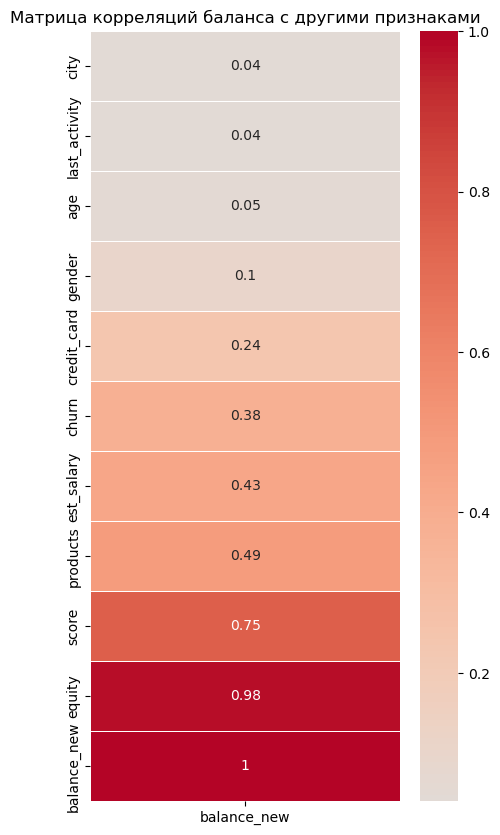

In [23]:
#Построим матрицу корреляции в виде графика sns.heatmap()
#Исключим столбец 'userid', чтобы не мешать наглядности корреляции
plt.figure(figsize=(5, 10))
sns.heatmap(phik_bank.loc[:,['balance_new']].drop('userid').sort_values('balance_new'),\
            cmap='coolwarm',center=0,linewidths=0.5,linecolor='white',annot=True)
plt.title(f'Матрица корреляций баланса с другими признаками')
plt.show()

Для оценки силы связи в теории корреляции применяется шкала английского статистика **Чеддока**:<a id="cheddock"></a> 

`слабая` — от 0,1 до 0,3; 

`умеренная` — от 0,3 до 0,5; 

`заметная` — от 0,5 до 0,7; 

`высокая` — от 0,7 до 0,9; 

`весьма высокая (сильная)` — от 0,9 до 1,0



Согласно шкале Чеддока у balance есть корреляция с

**сильной степени выраженности** с equity

**высокой степени выраженности** с score

**умеренная** с product, est_salary и churn

**слабой степени выраженности** credit_card и gender

Пропуски в balance классифицируются как MNAR (Missing Not At Random / Отсутствует не случайно) — пропуски зависят от данных, без дополнительного обоснования их нельзя отбрасывать или заполнять одним значением, т.к. это приведёт к заметным искажениям. Возможно они вызваны тем, что у клиентов  «Метанпром» банка нет дебетового счета, есть только кредитная карта или это новые клиенты. Также могла возникнуть техническая проблема при выгрузке,если есть возможность, то лучше отправить запрос разработчикам и уточнить. 
Поэтому корректно заполнить эти пропуски мы не можем - оставляем их без изменений

In [24]:
#Проверяем все внеченные изменения в наш df повторно
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9973 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   userid         9973 non-null   int64  
 1   score          9973 non-null   int64  
 2   city           9973 non-null   object 
 3   gender         9973 non-null   object 
 4   age            9973 non-null   int64  
 5   equity         9973 non-null   int64  
 6   balance        7695 non-null   float64
 7   products       9973 non-null   int64  
 8   credit_card    9973 non-null   int64  
 9   last_activity  9973 non-null   int64  
 10  est_salary     9973 non-null   float64
 11  churn          9973 non-null   int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 1012.9+ KB


In [25]:
#Для исследовательского анализа нам необходимо кодировать категориальные переменные в бинарные для "gender" и "city"
#Создадим копии столбцов city и gender:

df['city_new']= df['city']
df['gender_new']= df['gender']

#Кодируем данные в новых столбцах city_new и gender_new:

df = pd.get_dummies(df, columns = ['city_new', 'gender_new'])

#Переименуем новые столбцы
df = df.rename (columns = ({'city_new_Ростов':'Ростов', 
                            'city_new_Рыбинск':'Рыбинск',
                            'city_new_Ярославль':'Ярославль', 
                            'gender_new_Ж':'female_male', 
                            'gender_new_М':'male'}))
del df['male']
df.head()

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,Ростов,Рыбинск,Ярославль,female_male
0,183012,850,Рыбинск,Ж,25,1,59214.82,2,0,1,75719.14,1,False,True,False,True
1,146556,861,Рыбинск,Ж,37,5,850594.33,3,1,0,86621.77,0,False,True,False,True
2,120722,892,Рыбинск,Ж,30,0,NaN,1,1,1,107683.34,0,False,True,False,True
3,225363,866,Ярославль,Ж,51,5,1524746.26,2,0,1,174423.53,1,False,False,True,True
4,157978,730,Ярославль,М,34,5,174.00,1,1,0,67353.16,1,False,False,True,False


**Вывод по разделу "Предобработка данных"**:
- Привели название столбцов к змениному регистру
- Изменили типа данных в столбце "score" и "age" и привели к типу int64
- Обработали 73 неявных дубликата в столбце "userid"
- Исследовлаи природу пропусков в столбце "age" и "balance".Приняли решения пропуски в "age" удалить, в "balance" оставить без изменений

### 3. Исследовательский анализ данных <a id="analysis"></a> 

**Определим, какие переменные относятся к:**

`непрерывные`(используем среднюю или медиану) - 'score', 'age', 'balance', 'est_salary' 

`дискретные`(медиану) - 'equity', 'products'

`фиктивная(отражает наличие или отсутствие влияния некоторого категориального признака)`(медиана) - 'last_activity', 'credit_card'

`категорилаьные`(мода) - 'city','gender'

**Сравним портреты типичных клиентов (отточных и нет)**

In [26]:
df.describe()

,userid,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn
count,9.973000e+03,9973.000000,9973.000000,9973.000000,7.695000e+03,9973.000000,9973.000000,9973.000000,9.973000e+03,9973.000000
mean,2.610498e+05,848.671212,42.730773,2.630803,8.272456e+05,1.871653,0.680237,0.522912,1.477991e+05,0.182292
std,1.269257e+06,65.393153,12.175166,1.980060,1.980327e+06,0.792547,0.466408,0.499500,1.392871e+05,0.386105
min,9.456100e+04,642.000000,18.000000,0.000000,0.000000e+00,1.000000,0.000000,0.000000,2.546300e+03,0.000000
25%,1.429240e+05,802.000000,33.000000,0.000000,2.956987e+05,1.000000,0.000000,0.000000,7.525202e+04,0.000000
50%,1.728940e+05,853.000000,40.000000,3.000000,5.242953e+05,2.000000,1.000000,1.000000,1.196431e+05,0.000000
75%,2.015430e+05,900.000000,51.000000,4.000000,9.800512e+05,2.000000,1.000000,1.000000,1.745000e+05,0.000000
max,2.280750e+07,1000.000000,86.000000,9.000000,1.191136e+08,5.000000,1.000000,1.000000,1.395064e+06,1.000000


Так как у всех непрерывных величин нет выбросов, будет считать их среднее. Для баланса возьмем и среднее и медиану- так как есть выброс в минимальном значении.Относительную разницу посчитаем только для средних

In [27]:
df.columns

Index(['userid', 'score', 'city', 'gender', 'age', 'equity', 'balance',
       'products', 'credit_card', 'last_activity', 'est_salary', 'churn',
       'Ростов', 'Рыбинск', 'Ярославль', 'female_male'],
      dtype='object')

In [28]:
#Построим сводную таблицу для непрерывных величин и посчитаем относительную разницу средних по каждому признаку между сегментами
portrets = pd.pivot_table(df, 
           values=['score','age','balance','est_salary'],
           index=['churn'],
           aggfunc={'score': "mean", 'age': "mean",'balance':"mean",\
                    'est_salary': "mean"})
portrets = portrets.T
portrets['dif%'] = (portrets[1]/portrets[0]-1)*100
portrets.columns = [['Остаются','Уходят','Разница в %']]
round(portrets)

,Остаются,Уходят,Разница в %
age,43.0,41.0,-4.0
balance,733032.0,1134458.0,55.0
est_salary,147675.0,148357.0,0.0
score,845.0,863.0,2.0


In [29]:
#Построим сводную таблицу для дискретных и фиктивных величин
portrets_1 = pd.pivot_table(df, 
           values=['equity','balance','products','credit_card','last_activity'],
           index=['churn'],
           aggfunc={'equity':"median",'balance':"median",\
                    'products': "median",'credit_card': "median",'last_activity': "median" })
portrets_1 = portrets_1.T
portrets_1.columns = [['Остаются','Уходят']]
round(portrets_1)

,Остаются,Уходят
balance,475410.0,783909.0
credit_card,1.0,1.0
equity,3.0,4.0
last_activity,0.0,1.0
products,2.0,2.0


In [30]:
#Построим таблицу для категориальных переменных
portrets_2 = df.groupby('churn')[['city','gender']].agg(pd.Series.mode).T
portrets_2.columns = [['Остаются','Уходят']]
portrets_2

,Остаются,Уходят
city,Ярославль,Ярославль
gender,Ж,М


In [31]:
#соберем все признаки в общую таблицу
portrets_concat = pd.concat([
    round(portrets),
    portrets_1,portrets_2
], axis=0)
round(portrets_concat,0)

,Остаются,Уходят,Разница в %
age,43.0,41.0,-4.0
balance,733032.0,1134458.0,55.0
est_salary,147675.0,148357.0,0.0
score,845.0,863.0,2.0
balance,475410.09,783908.9,NaN
credit_card,1.0,1.0,NaN
equity,3.0,4.0,NaN
last_activity,0.0,1.0,NaN
products,2.0,2.0,NaN
city,Ярославль,Ярославль,NaN


**На основе сравнения показателей можно составить 2 портрета клиентов:<a id="income"></a>**

**`Портрет отточного клиента`**:

Возраст - 41 год

Баланс по медиане- 783 909

Доход - 148 357

Баллы кредитного скоринга - 863

Кредитная карта - есть

Баллы собственности - 4

Активен за последние 3 месяца - да

Количество продуктов банка - 2

Город - Ярославль

Пол - Мужской

**`Портрет клиента, который остается с банком`**:

Возраст - 43 года

Баланс по медиане- 475 410

Доход - 147 675

Баллы кредитного скоринга - 845

Кредитная карта - есть

Баллы собственности - 3

Активен за последние 3 месяца - нет

Количество продуктов банка - 2

Город - Ярославль

Пол - Женский


Город и кол-во продуктов схожи для отточных и не отточных клиентов, поэтому не явлются отличительными параметрами. Отточные клиенты являются более состоятельными: у них на 65% выше баланс, имеют выше балл кредитного скоринга и имеют больше баллов собственности. Равенство доходов необходимо проверить с помощью стат.гипотезы

**Для дальнейшего анализа необходимо исследовать все переменные для отточных и не отточных клиентов**

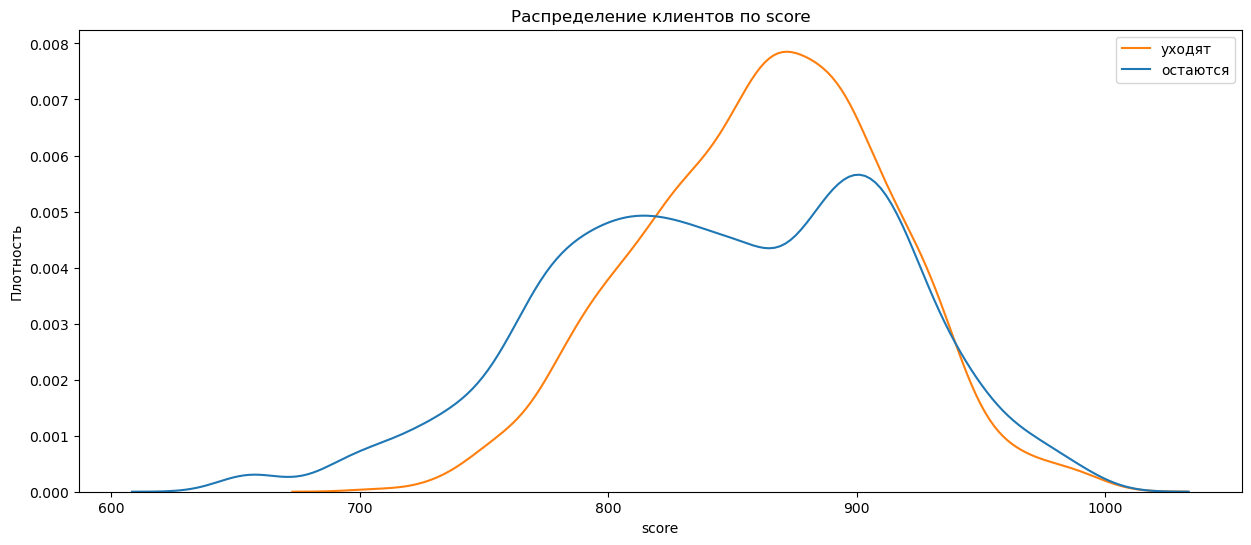

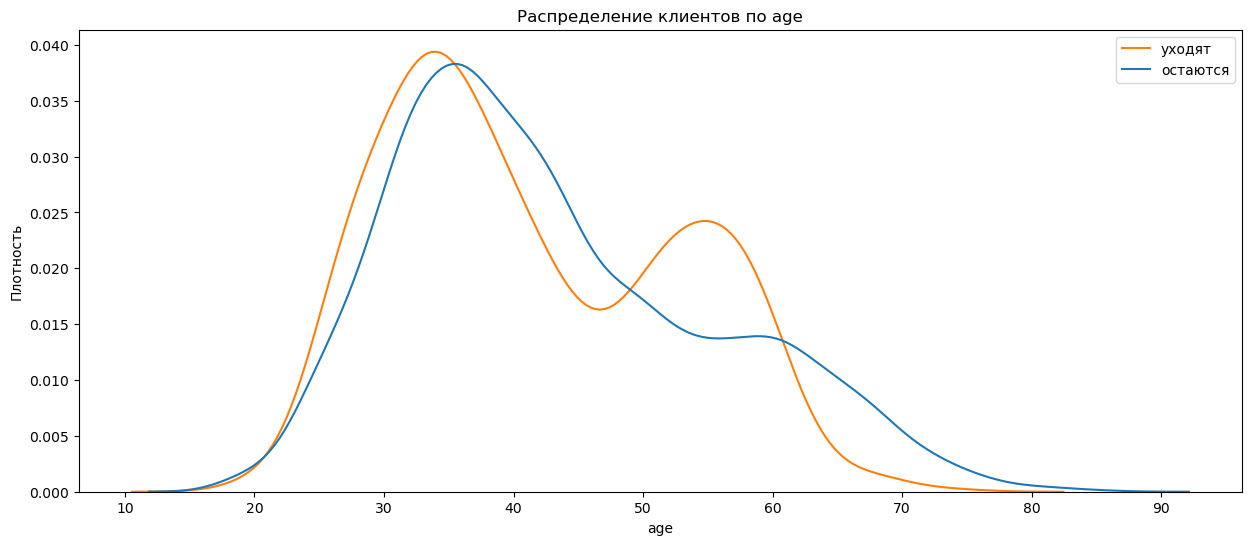

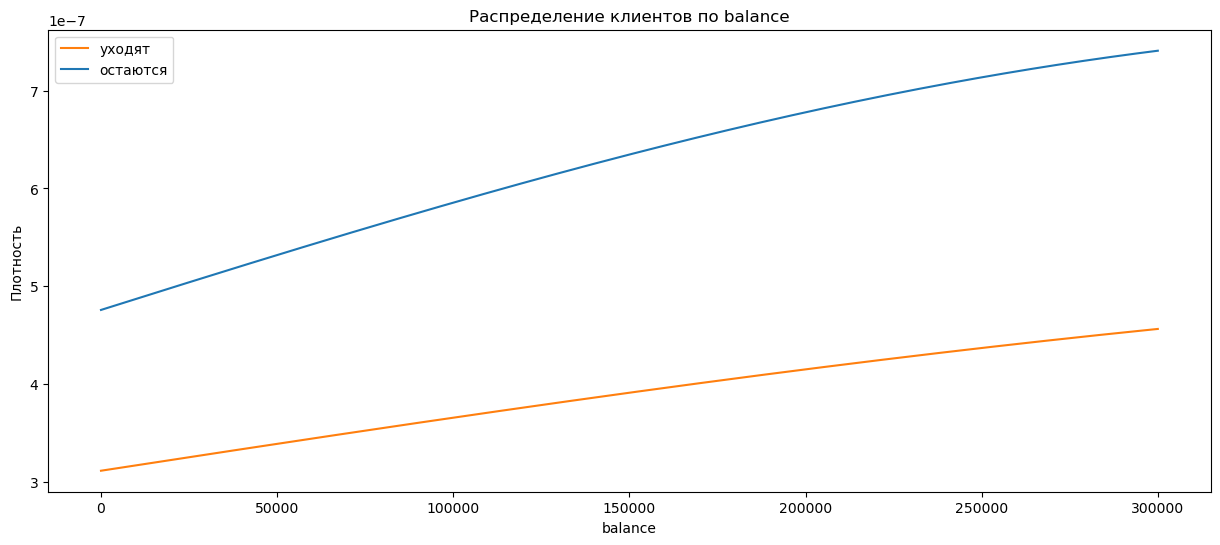

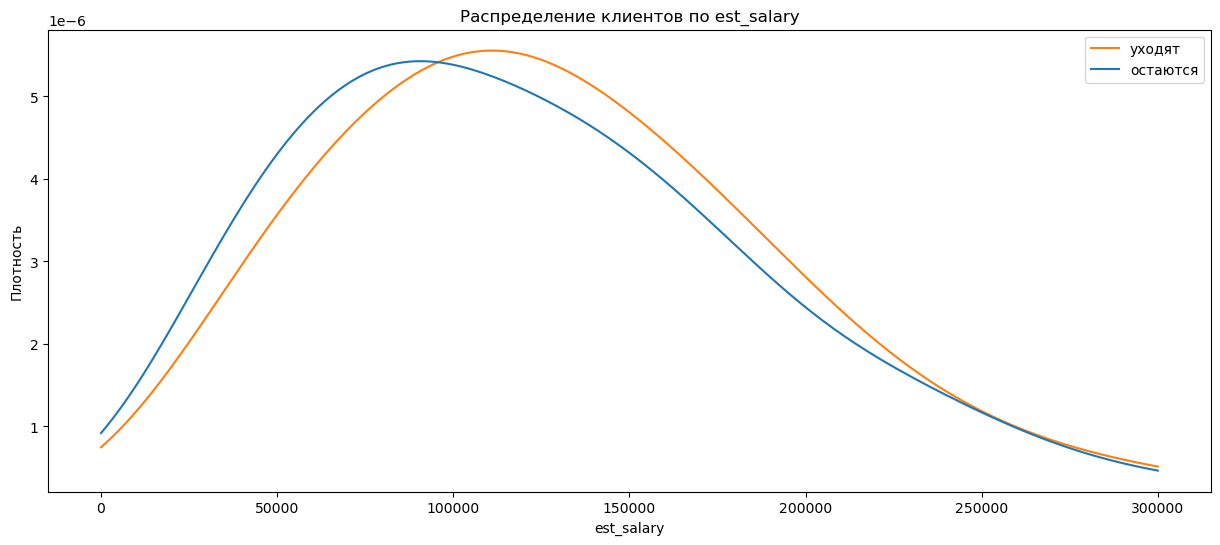

In [32]:
#Для непрерывных переменных строим график распределения
for column in ['score', 'age', 'balance', 'est_salary']:
    plt.figure(figsize=(15,6))
    sns.kdeplot(data=df,x=column, hue='churn', common_norm=False, clip=(0, 300000))
    plt.title(f'Распределение клиентов по {column}')
    plt.legend(['уходят','остаются'])
    plt.ylabel('Плотность')
    plt.show()

Для balance построим допольнительный график распределения, чтобы он был нагляднее

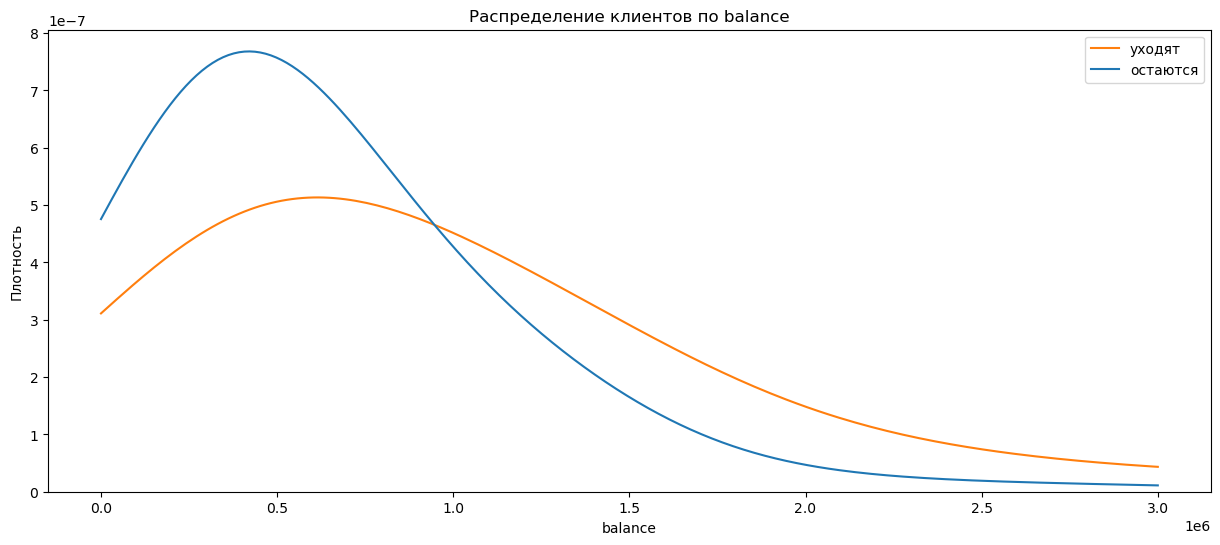

In [33]:
plt.figure(figsize=(15,6))
sns.kdeplot(data=df,x='balance', hue='churn', common_norm=False, clip=(0, 3000000))
plt.title(f'Распределение клиентов по balance')
plt.legend(['уходят','остаются'])
plt.ylabel('Плотность')
plt.show()

**Графики распределения для непрерывных величин показали, что:**

`score` (баллы кредитного скоринга без разбивки на рейтинги) - отток клиентов преобладает с значениями в диапазоне с 820 до 950 баллов

`age` (возраст) - отток клиентов преобладает для 2х возрастных групп с 22-35 лет и с 50-62 лет

`balance` (баланс на счёте на момент выгрузки) - отточные клиенты балансом более 1 млн. 

`est_salary`(оценочный доход клиента(любой доход, оценивается раз в 3 месяца) -  отток преобладает для клиентов от 100 до 250 тысяч


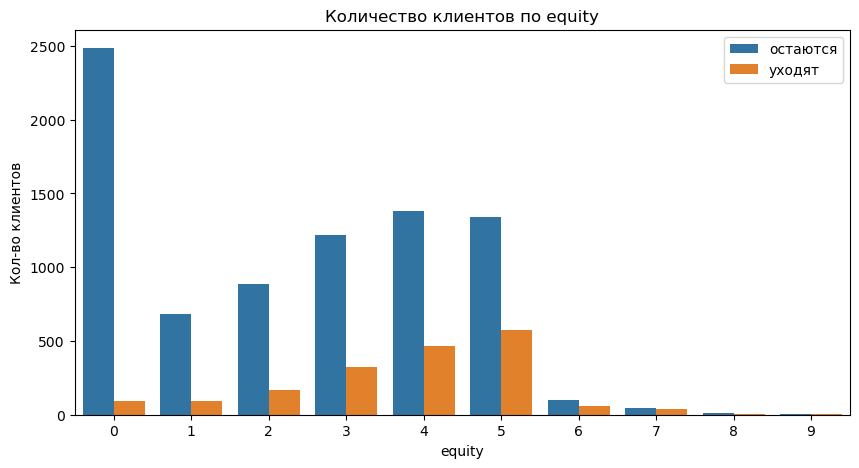

In [34]:
#Посмотрим абсолютные значения клиентов для дискретных величин в зависимости от признака оттока
plt.figure(figsize=(10,5))
sns.countplot(data=df, x='equity', hue='churn')
plt.title(f'Количество клиентов по equity')
plt.ylabel('Кол-во клиентов')
plt.legend(['остаются','уходят'])
plt.show()

Абсолютные значения нам показали, что на каждое кол-во баллов собственности больше клиентов, которые осотаются в банке, чем тех, которые собрались уходить. И чем больше баллов, тем больше отточных клиентов. Но график не дает нам понимания, превышает ли показатели ооточности средний уровень оттока по банку(***18.2%*** согласно describe). Поэтому для  дискретных и категориальных величин в дальнейшем мы будем рассматривать не только абсолютные значения, но и долю отточных клиентов для каждого параметра в отдельности

In [35]:
#Зададим функцию расчета долей для каждого параметра
def ms_parametr(column):
    ms = []
    ms = (df
    .groupby(column)
    .agg(count=('churn', 'count'), sum=('churn', 'sum'))
    .assign(share=lambda x: x['sum'] / x['count']*100).round(2)
    )
    return ms

In [36]:
#Проверяем
ms_parametr('city')

,count,sum,share
city,,,
Ростов,1416,265,18.71
Рыбинск,2682,436,16.26
Ярославль,5875,1117,19.01


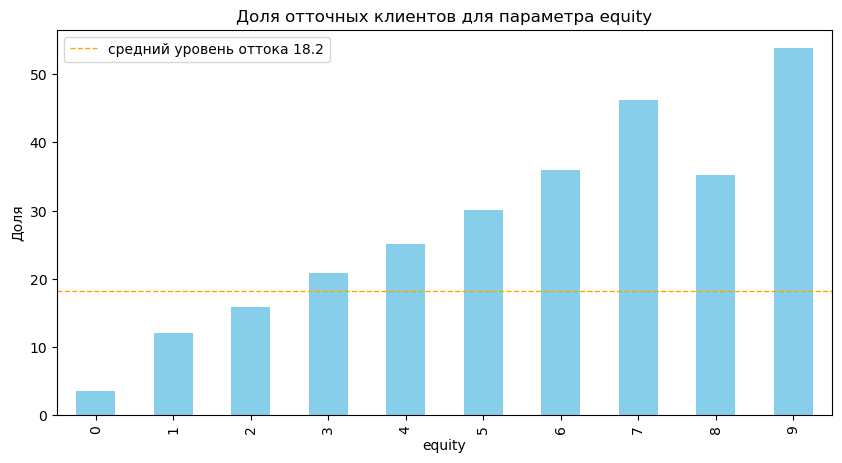

In [37]:
#Построим график барплот для оценки доли отточных клиентов на основе функции выше

my_val = df.churn.mean()*100 #Уровень среднего оттока 18.2%
ms_parametr('equity')['share'].plot(kind='bar',
                                    title = 'Доля отточных клиентов для параметра equity',
                                    xlabel = 'equity', 
                                    ylabel = 'Доля', 
                                    color = 'skyblue',
                                    figsize=(10,5)).axhline(y=my_val,c='orange',linewidth=1, linestyle='--')
plt.legend(labels=['средний уровень оттока 18.2'])
plt.show()#Проверяем

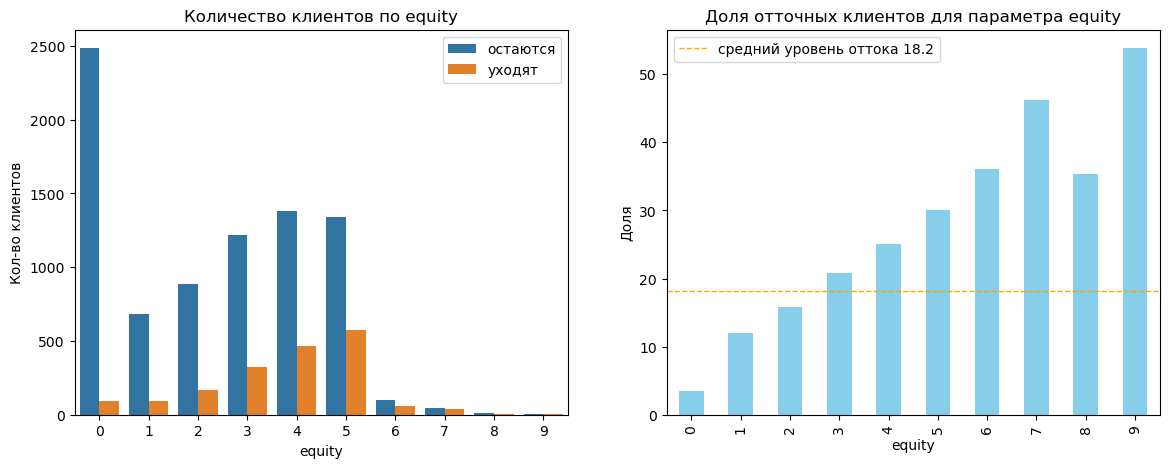

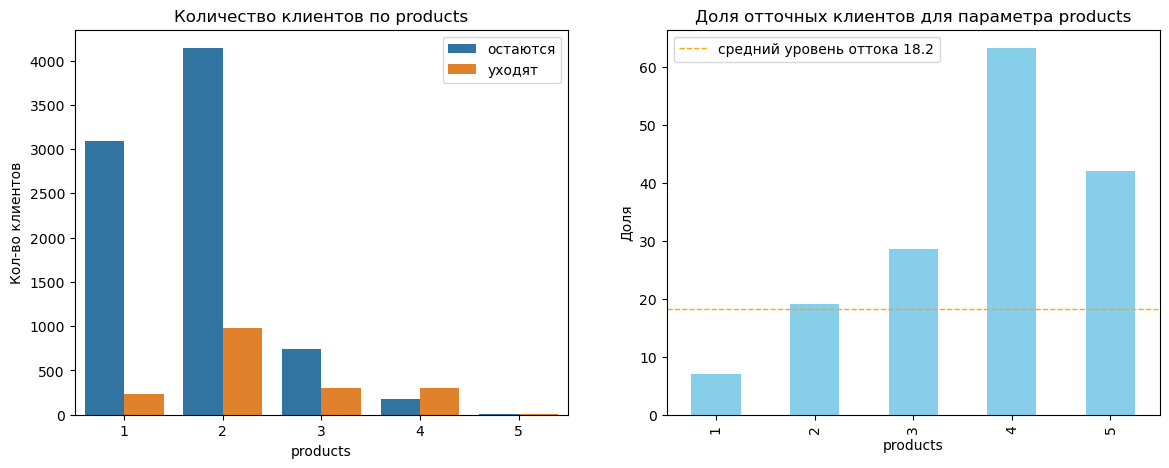

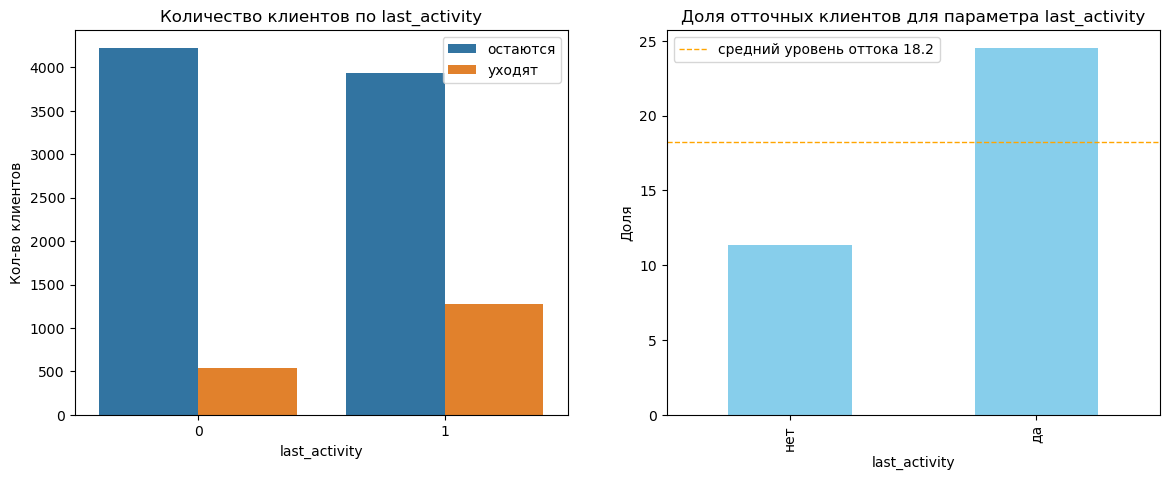

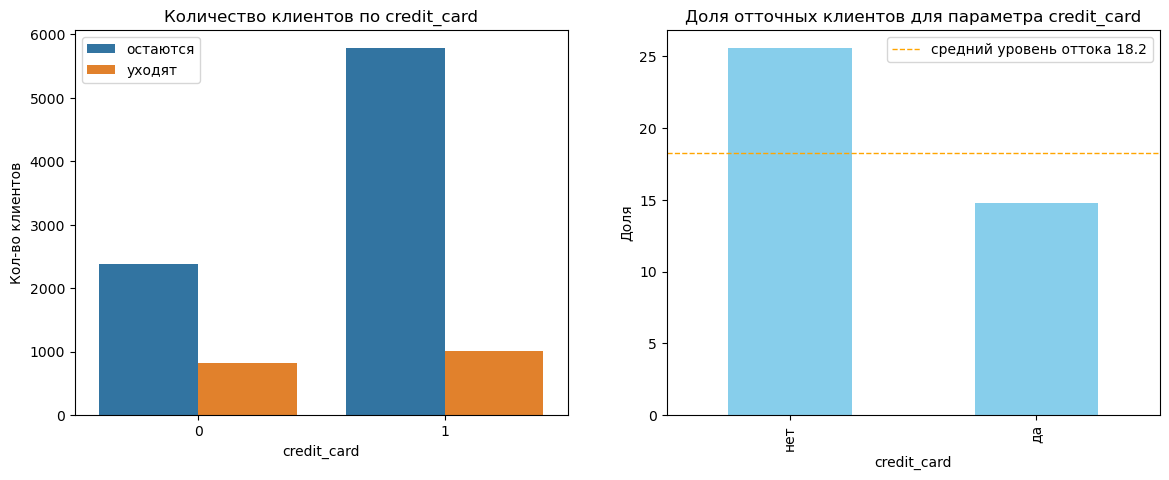

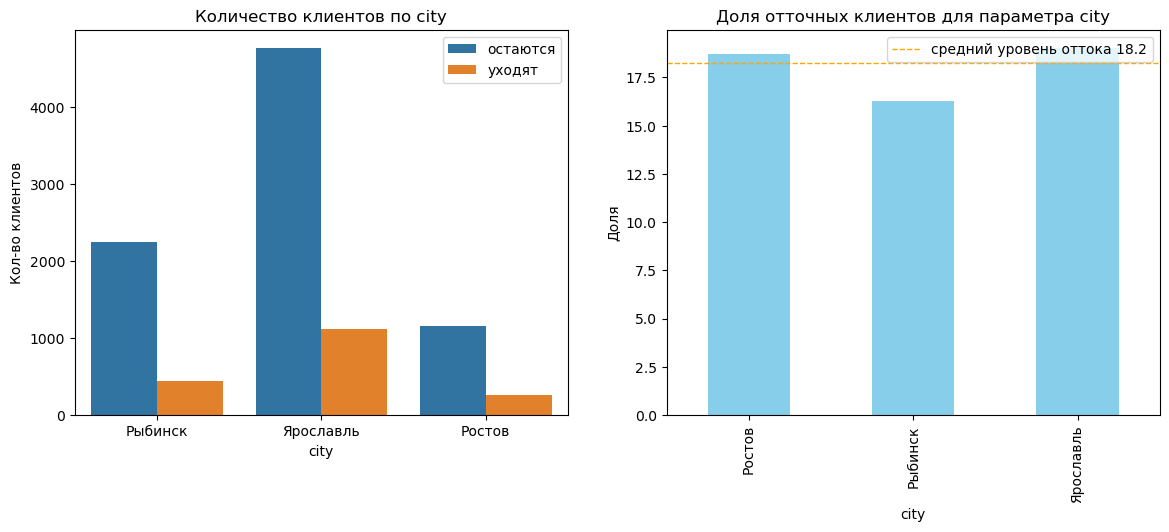

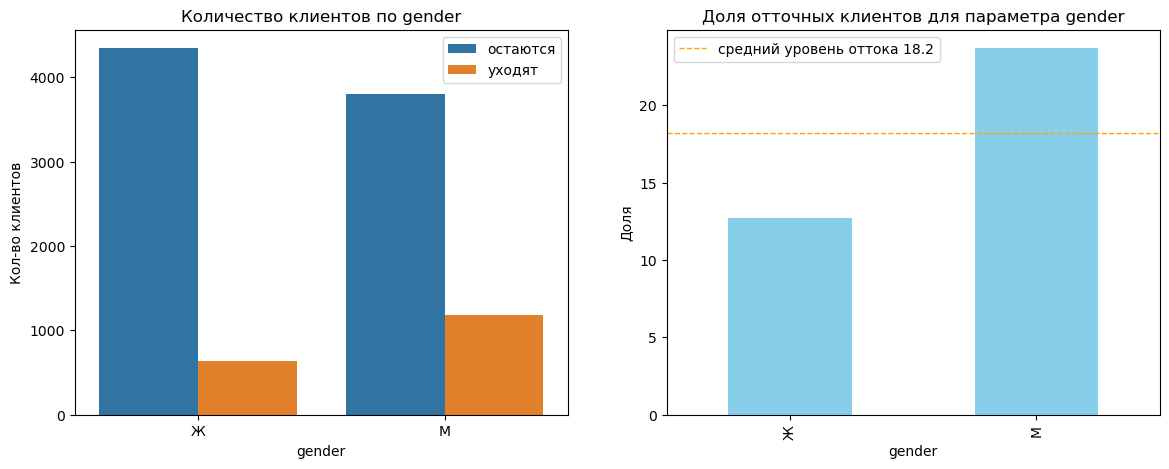

In [38]:
#Объеденим 2 графика для каждого параметра(с абсолютными значениями и с долей)
binary_columns = ['last_activity','credit_card']
for i,columns in enumerate(['equity','products','last_activity', 'credit_card','city','gender']): 
    ax1 = plt.subplot(1, 2, 1)
    ax2 = plt.subplot(1, 2, 2)
    sns.countplot(data = df, 
                  x = df[columns], 
                  hue = 'churn',
                  ax = ax1).set(ylabel='Кол-во клиентов')
    
    my_val = df.churn.mean()*100 #Уровень среднего оттока 18.2%
    ms_parametr(columns)['share'].plot(kind='bar',
                                    title = f'Доля отточных клиентов для параметра {columns}',
                                    xlabel = columns,
                                    ylabel = 'Доля',
                                    color = 'skyblue',
                                    figsize=(14,5),ax=ax2).axhline(y=my_val,c='orange',linewidth=1, linestyle='--')
    ax1.set_title(f'Количество клиентов по {columns}')
    ax1.legend(labels=['остаются','уходят'])
    ax2.legend(labels=['средний уровень оттока 18.2'])
    if columns in binary_columns:
        ax2.set_xticks(ticks=[0, 1], labels=['нет', 'да'])
    plt.show()

- Для всех параметров `equity`,`products`,`last_activity`, `credit_card`,`city`,`gender` в абсолютных значениях кол-во остающихся клиентов превышает кол-во отточных клиентов
- Для `equity` основной отток начинается для клиентов имеющих 3 балла собственности и более - тенденция оттока для состоятельных клиентов
- Для `products` от 2х продуктов и более процент оттока превышает средний уровень оттока по банку
- Для `last_activity`в абсолютном и долевом соотношении чаще уходят активные клиенты(доля оттока почти 25%)
- Для `credit_card` доля клиентов без кредитной карты первышает средний уровень оттока по банку (доля оттока 25%)
- Для `city`<a id="share"></a> самый крупный филиал в Ярославле по абсолютным знаечниям.Но доля отточных клиентов для Ярославля и Ростова кажется одинаковой (около 18.5%), что незначительно, но превышает средний отток по банку.Проверим стат.гипотезой
- Для `gender` в абсолютном и долевом значении чаще поддвержены оттоку мужчины (около 25% доля оттока)

**Исследуем корреляцию всех признаков таблицы**

Для интерпретации результатов обратимся к [**шкале корреляции Чеддока**](#cheddock)

In [39]:
#Для расчета корреляции будем использовать библиотеку phik
#Она сразу работает со всеми признаками, считая нужный тип корреляции в зависимости от принадлежности признака к той или иной категории
#параметр interval_cols содержит список непрерывных признаков(score,age,est_salary)
phik_corr = df.phik_matrix(interval_cols= ['score','age','balance','est_salary',]).round(2)
phik_corr

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,Ростов,Рыбинск,Ярославль,female_male
userid,1.0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
score,1.0,1.00,0.09,0.07,0.03,0.53,0.17,0.42,0.21,0.05,0.40,0.23,0.09,0.03,0.08,0.07
city,1.0,0.09,1.00,0.01,0.09,0.06,0.04,0.13,0.07,0.03,0.17,0.02,1.00,1.00,1.00,0.01
gender,1.0,0.07,0.01,1.00,0.29,0.06,0.05,0.07,0.20,0.01,0.14,0.22,0.02,0.02,0.03,1.00
age,1.0,0.03,0.09,0.29,1.00,0.05,0.02,0.14,0.16,0.09,0.36,0.19,0.07,0.06,0.09,0.29
equity,1.0,0.53,0.06,0.06,0.05,1.00,0.00,0.58,0.22,0.05,0.29,0.35,0.06,0.00,0.05,0.06
balance,1.0,0.17,0.04,0.05,0.02,0.00,1.00,0.00,0.00,0.00,0.37,0.02,0.00,0.02,0.05,0.05
products,1.0,0.42,0.13,0.07,0.14,0.58,0.00,1.00,0.27,0.11,0.22,0.26,0.04,0.09,0.11,0.07
credit_card,1.0,0.21,0.07,0.20,0.16,0.22,0.00,0.27,1.00,0.05,0.04,0.20,0.15,0.08,0.18,0.20
last_activity,1.0,0.05,0.03,0.01,0.09,0.05,0.00,0.11,0.05,1.00,0.04,0.26,0.00,0.07,0.07,0.01


In [40]:
#Исключим столбец 'userid',а также не закодированные city и gender чтобы не мешал построению матрицы, утстановив его в качестве индекса
df_new = df.set_index('userid').drop(['city','gender'], axis =1)
#Занаво рассчитаем корреляцию с библиотекой phik
phik_corr = df_new.phik_matrix(interval_cols= ['score','age','balance','est_salary',]).round(2)
phik_corr

,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn,Ростов,Рыбинск,Ярославль,female_male
score,1.00,0.03,0.53,0.17,0.42,0.21,0.05,0.40,0.23,0.09,0.03,0.08,0.07
age,0.03,1.00,0.05,0.02,0.14,0.16,0.09,0.36,0.19,0.07,0.06,0.09,0.29
equity,0.53,0.05,1.00,0.00,0.58,0.22,0.05,0.29,0.35,0.06,0.00,0.05,0.06
balance,0.17,0.02,0.00,1.00,0.00,0.00,0.00,0.37,0.02,0.00,0.02,0.05,0.05
products,0.42,0.14,0.58,0.00,1.00,0.27,0.11,0.22,0.26,0.04,0.09,0.11,0.07
credit_card,0.21,0.16,0.22,0.00,0.27,1.00,0.05,0.04,0.20,0.15,0.08,0.18,0.20
last_activity,0.05,0.09,0.05,0.00,0.11,0.05,1.00,0.04,0.26,0.00,0.07,0.07,0.01
est_salary,0.40,0.36,0.29,0.37,0.22,0.04,0.04,1.00,0.05,0.14,0.10,0.18,0.14
churn,0.23,0.19,0.35,0.02,0.26,0.20,0.26,0.05,1.00,0.00,0.05,0.03,0.22
Ростов,0.09,0.07,0.06,0.00,0.04,0.15,0.00,0.14,0.00,1.00,0.38,0.69,0.02


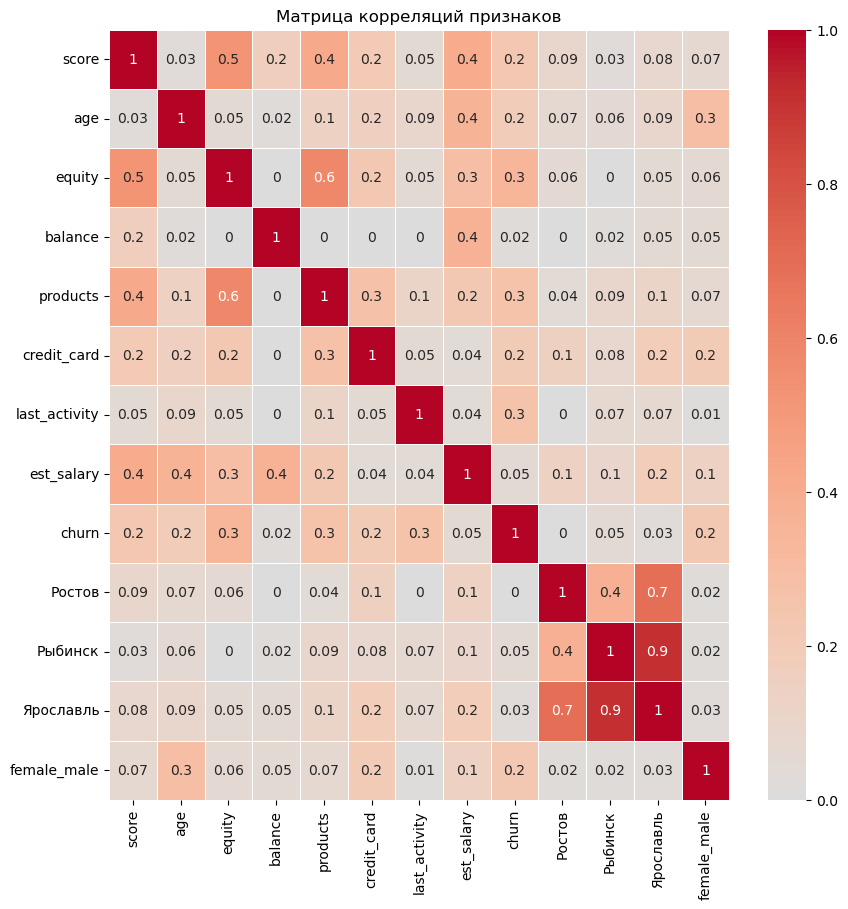

In [41]:
#Построим матрицу корреляции в виде графика sns.heatmap()
plt.figure(figsize=(10, 10))
sns.heatmap(phik_corr.round(2),fmt='.1g',\
            cmap='coolwarm',center=0,linewidths=0.5,linecolor='white',annot=True)
plt.title(f'Матрица корреляций признаков')
plt.show()

Согласно шкале Чеддока корреляция:

**сильной степени выраженности (от 0,9 до 1,0)** между кодированным столбцами городов Ярославль-Рыбинск,и между гендерами female-male

**высокой степени выраженности (от 0,7 до 0,9 )**  Ярославль-Ростов

**заметная (от 0,5 до 0,7)** score-equity,equity-products

**умеренная ( от 0,3 до 0,5)** score-product,score-est_salary, age-male, age-female,age-est_salary,equity-est_salary, equity-churn,balance-est_salary,product-churn, product-credit_card, last_activity-churn

**слабой степени выраженности (от 0,1 до 0,3)** - не рассматриваем


**Сделаем фокус на анализе корреляции признаков с признаком оттока**

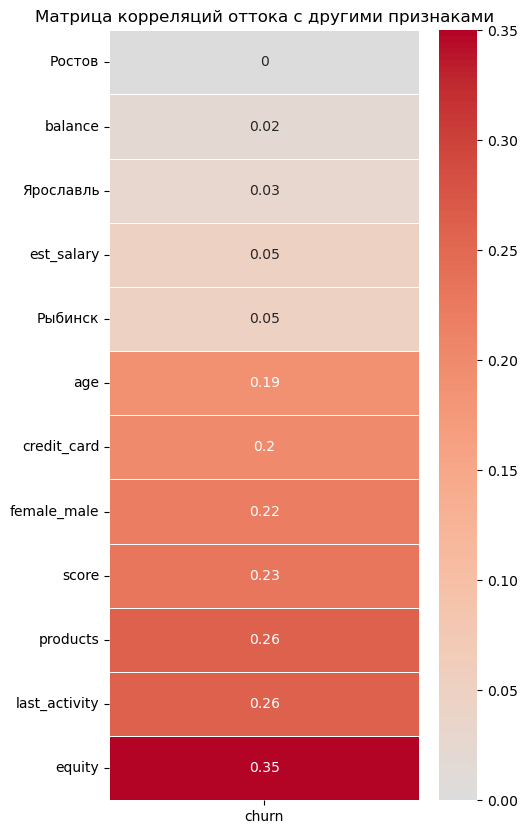

In [42]:
plt.figure(figsize=(5, 10))
sns.heatmap(phik_corr.loc[:,['churn']].drop('churn').sort_values('churn'),\
            cmap='coolwarm',center=0,linewidths=0.5,linecolor='white',annot=True)
plt.title(f'Матрица корреляций оттока с другими признаками')
plt.show()

- Есть умеренная корреляция признака оттока(churn) c количеством баллов собственности(equity)
- И слабовыраженная кореляция с last_activity, products, score, male,female,credit_card,age

**Вывод по разделу "Исследовательский анализ"**:

- Сформировали 2 портрета клиента (отточного и нет) и сделали вывод, что город и кол-во продуктов схожи для отточных и не отточных клиентов, поэтому не явлются отличительными параметрами. Отточные клиенты являются более состоятельными: у них на 65% выше баланс, имеют выше балл кредитного скоринга и имеют больше баллов собственности

- Исследовали каждый параметр в разрезе оттока:

  - score (баллы кредитного скоринга без разбивки на рейтинги) - отток клиентов преобладает с значениями в диапазоне с 820 до 950 баллов

  - age (возраст) - отток клиентов преобладает для 2х возрастных групп с 22-35 лет и с 50-62 лет

  - balance (баланс на счёте на момент выгрузки) - отточные клиенты балансом более 1 млн.

  - est_salary(оценочный доход клиента(любой доход, оценивается раз в 3 месяца) - отток преобладает для клиентов с доходом выше 100 тысяч
    
  - Для всех параметров `equity`,`products`,`last_activity`, `credit_card`,`city`,`gender` в абсолютных значениях кол-во остающихся клиентов превышает кол-во отточных клиентов
    
  - Для `equity` основной отток начинается для клиентов имеющих 3 балла собственности и более - тенденция оттока для состоятельных клиентов
    
  - Для `products` от 2х продуктов и более процент оттока превышает средний уровень оттока по банку
    
  - Для `last_activity`в абсолютном и долевом соотношении чаще уходят активные клиенты(доля оттока почти 25%)
    
  - Для `credit_card` доля клиентов без кредитной карты первышает средний уровень оттока по банку (доля оттока 25%)

  - Для `city` самый крупный филиал в Ярославле по абсолютным знаечниям.Но доля отточных клиентов для Ярославля и Ростова одинаковые (18.5%), что незначительно, но превышает средний отток по банку

  - Для `gender` в абсолютном и долевом значении чаще поддвержены оттоку мужчины (около 25% доля оттока)
 
- Исследовали корреляцию и интерпретировали результат по шкале Чеддока:

  - сильная степень выраженности (от 0,9 до 1,0) между кодированным столбцами городов Ярославль-Рыбинск,и между гендерами female-male

  - высокая степень выраженности (от 0,7 до 0,9 ) Ярославль-Ростов

  - заметная (от 0,5 до 0,7) score-equity,equity-products

  - умеренная ( от 0,3 до 0,5) score-product,score-est_salary, age-male, age-female,age-est_salary,equity-est_salary, equity-churn,balance-est_salary,product-churn, product-credit_card, last_activity-churn

  - слабая степени выраженности (от 0,1 до 0,3) - не рассматриваем
 
- Сделали фокус на анализе корреляции признаков с признаком оттока (churn) и выявили умеренную корреляция c количеством баллов собственности(equity и слабовыраженную кореляция с last_activity, products, score, male,female,credit_card,age

### 4. Проверка статистических гипотез<a id="stat"></a> 

**1. Проверить гипотезу различия [**дохода**](#income) между теми клиентами, которые ушли и теми, которые остались**

Чтобы понять, можно ли применять t-тест, нужно проверить три условия:

- ***Генеральные совокупности не зависят друг от друга.*** - не зависят

- ***Выборочные средние нормально распределены.***
   При проведении параметрических тестов важно соблюдать условие нормальности распределения. Распределение статистики критерия не будет нормальным, если в выборке не нормальное распределение. Вероятность, что среднее в выборке попадёт в критическую область(рассчитанную для
нормального распределения),будет выше, чем 0.05 –увеличится ошибка 1-го рода(вероятность найти различия, где их нет).
**Нормальность распределения можно проверить криетрием Шапиро-Уилка** - обнаруживает различия между распределениями, если они и правда есть.
Слабые отклонения от нормального распределения не очень страшны (в силу Центральной предельной теоремы), а для больших выборок ими
можно пренебречь (кроме регрессионного анализа).

- ***Дисперсии рассматриваемых генеральных совокупностей равны.***
  С одной стороны, вы никогда точно не знаете, равны ли дисперсии рассматриваемых генеральных совокупностей. С другой — по умолчанию параметр equal_var принимает значение True: дисперсии считаются равными и тест объединяет обе выборки в одну, чтобы эту дисперсию поточнее оценить.При этом если выборки достаточно велики (30 и больше значений) и равны по размеру между собой, то такой подход оправдан. Симуляции, проведённые учёными, показывают, что даже если дисперсии на самом деле не равны, то тест редко ошибается. Равность дисперсий можно проверить **тестом Левена**

In [43]:
#Проверим данные на нормальность для отточных клиентов критерием Шапиро-Уилка

alpha = 0.05  # критический уровень статистической значимости

results = st.shapiro(df[df['churn'] == 1]['est_salary'])
p_value = results[1]  # второе значение в массиве результатов (с индексом 1) - p-value

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: распределение не нормально для отточных клиентов')
else:
    print('Не получилось отвергнуть нулевую гипотезу, всё нормально') 

p-значение:  7.6098901777717e-52
Отвергаем нулевую гипотезу: распределение не нормально для отточных клиентов


In [44]:
#Проверим данные на нормальность лояльных клиентов критерием Шапиро-Уилка

alpha = 0.05  # критический уровень статистической значимости

results = st.shapiro(df[df['churn'] == 0]['est_salary'])
p_value = results[1]  # второе значение в массиве результатов (с индексом 1) - p-value

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: распределение не нормально для лояльных клиентов')
else:
    print('Не получилось отвергнуть нулевую гипотезу, всё нормально') 

p-значение:  2.8456627543974057e-86
Отвергаем нулевую гипотезу: распределение не нормально для лояльных клиентов


Гипотеза о нормальности распределения как для отточных, так и для лояльных клиентов была отвергнута.Построим график распределения для наглядности

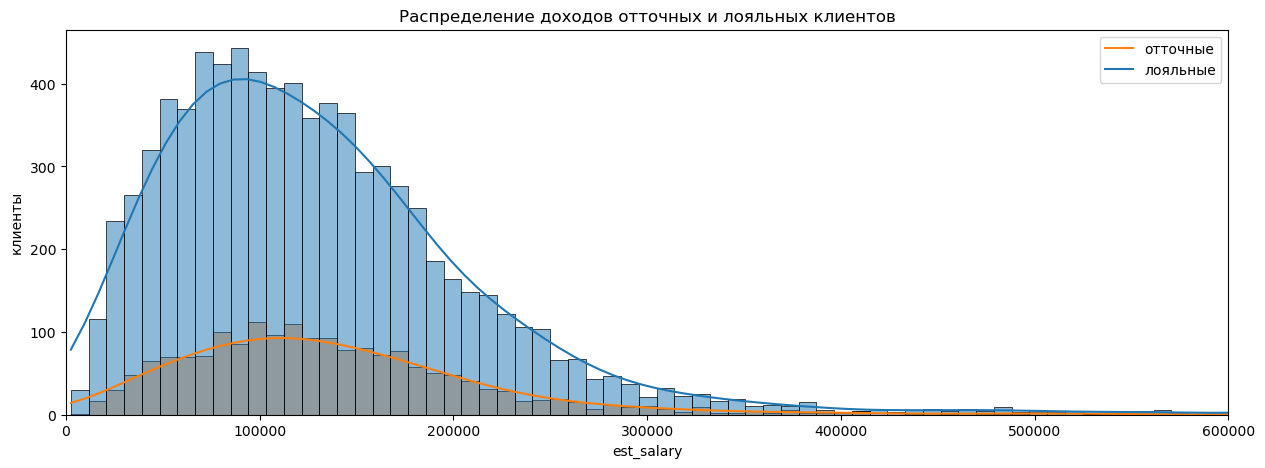

In [45]:
plt.figure(figsize=(15, 5))
sns.histplot(data=df,x='est_salary', hue='churn', common_norm=False,kde=True)
plt.ylabel('клиенты')
plt.xlabel('est_salary')
plt.xlim(0,600000)
plt.title('Распределение доходов отточных и лояльных клиентов')
plt.legend(['отточные','лояльные'])
plt.show()

Распределение positively skewed - скошенное вправо

In [46]:
#Levene's test centered at the median
st.levene(df[df['churn'] == 1]['est_salary'], df[df['churn'] == 0]['est_salary'], center='median')


LeveneResult(statistic=6.659643229714454, pvalue=0.009876226357398085)

In [47]:
#Проверим равность дисперсий тестом Левена по медиане

results = st.levene(df[df['churn'] == 1]['est_salary'], df[df['churn'] == 0]['est_salary'], center='median')
p_value = results[1]

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: дисперсии не равны')
else:
    print('Не получилось отвергнуть нулевую гипотезу, дисперсии равны') 


p-значение:  0.009876226357398085
Отвергаем нулевую гипотезу: дисперсии не равны


In [48]:
#Проверим равность дисперсий тестом Левена по среднему

results = st.levene(df[df['churn'] == 1]['est_salary'], df[df['churn'] == 0]['est_salary'], center='mean')
p_value = results[1]

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: дисперсии не равны')
else:
    print('Не получилось отвергнуть нулевую гипотезу, дисперсии равны') 


p-значение:  0.0014509244558742439
Отвергаем нулевую гипотезу: дисперсии не равны


В обоих методах p-значение составляет менее 0,05. Это означает, что в обоих случаях мы отвергаем нулевую гипотезу.
Группы отточных и лояльных клиентов имеют не равные дисперсии.

Рассчитаем дисперсии для наглядности

In [49]:
print('Дисперcия отточных клиентов',df[df['churn'] == 1]['est_salary'].var())
print('Дисперсия лояльных клиентов',df[df['churn'] == 0]['est_salary'].var())
print('Дисперсия различаются на %:',((df[df['churn'] == 0]['est_salary'].var()/df[df['churn'] == 1]['est_salary'].var())-1)*100)

Дисперcия отточных клиентов 15112272166.8834
Дисперсия лояльных клиентов 20358839437.943947
Дисперсия различаются на %: 34.71726298417073


Расчетные диспресии не равны

**Вывод:**
 
- Благодаря ЦПТ (Если размер выборки составляет хотя бы несколько десятков значений, то выборочные средние, которые можно получить из одной и той же генеральной совокупности, будут распределены близко к нормальному вокруг истинного среднего этой совокупности. Это так, даже если сама генеральная совокупность не распределена нормально). Так как гипотезу о равенстве дисперсий мы отклонили, то параметру equal_var присвоим знаечние False - **мы можем использовать ttest(t-критерий Стьюдента)**
- Так как гипотезы о нормальности распределения и о равенстве дисперсий мы отвергли, можем использовать непараметрические методы, например **U-критерий Манна-Уитни**

`Н0 гипотеза` : Доход между отточными и лояльными клиентами равны

`Н1 гипотеза` : Доход между отточными и лояльными клиентами не равны

In [50]:
#Проверим гипотезу ttest(t-критерий Стьюдента)

results = st.ttest_ind(df[df['churn']==0]['est_salary'], 
                       df[df['churn']==1]['est_salary'],
                       equal_var=False)

print('p-значение: ', results.pvalue)# тест двухсторонний

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.8354803526840116
Не получилось отвергнуть нулевую гипотезу


In [51]:
#Проверим гипотезу  U-критерий Манна-Уитни

results = st.mannwhitneyu(df[df['churn']==0]['est_salary'], 
                          df[df['churn']==1]['est_salary'])

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя') 


p-значение:  0.00016830729188229058
Отвергаем нулевую гипотезу


**Вывод:**

Результаты проверки для t-критерия Стьюдента и для u-критерия Манна-Уитни различины.

Причин разлиичия может быть несколько:

Структура исходных данных: при наличие выбросов алгебраические метрики работают плохо,одно выбивающееся значение существенно влияет на результат t-теста. U-тест, основанный на структурном подходе, работает с рангами и никак не учитывая сами значения. Поэтому результаты не искажаются из-за выбросов, сильно сдвигающих параметрические результаты.

Несоблюдение уловий t-критерия: Если нет уверенности в нормальности распределения признака или гомогенности дисперсий, то лучше применить U-тест,так как он лучше обрабатывает такие данные. А t-тест может дать неверные результаты

Чувствительность тестов: t-тест более чувствителен к различиям в средних значениях. U-тест более чувствителен к различиям в распределении данных между выборками.U-тест может обнаружить значимую разницу в случае если распределения в двух выборках различаются,  даже если средние схожи.

**Различия в распределении доходов между отточными и лояльными клиентами могут быть статистически значимыми, несмотря на схожесть средних доходов.Поэтому результат мы будем интерпретировать по U-тесту:Отвергаем нулевую гипотезу.Статистически значимая разница между доходами отточных и лояльных клиентов есть**

**2. Проверить гипотезу различия [**доли**](#share) отточных клиентов между городами Ярославль и Ростов**

`Н0 гипотеза` : Доли отточных клиентов между городами Ярославль и Ростов равны

`Н1 гипотеза` : Доли отточных клиентов между городами Ярославль и Ростов не равны

In [52]:
# Проверим гипотезу о равенстве доле z-тестом

df_agg = df.groupby('city').agg(count=('churn', 'count'), sum=('churn', 'sum')).drop('Рыбинск')


df_sum = df_agg['sum']
df_count = df_agg['count']

successes = np.array([df_sum['Ярославль'],df_sum['Ростов']])
trials = np.array([df_count['Ярославль'],df_count['Ростов']])

# пропорция успехов в первой группе:
p1 = successes[0]/trials[0]

# пропорция успехов во второй группе:
p2 = successes[1]/trials[1]

# пропорция успехов в комбинированном датасете:
p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

# разница пропорций в датасетах
difference = p1 - p2 

# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1)  

p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными') 


p-значение:  0.7972641864666052
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**По результатам z-теста не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными для отточных клиентов в Ярославле и Ростове**

### 5. Сегментация и приоритизация клиентов<a id="segment"></a> 

**Cуммарная доля всех сегментрованных пользователей должна быть выше 35% от общего числа отточных клиентов сегмента**

Еще раз выделим признаки отточности и определены их интервалы, включающие наибольший процент оттока клиентов:

**`Портрет отточного клиента`**:

Возраст - 41 год

Баланс по медиане- 783 909

Доход - 148 357

Баллы кредитного скоринга - 863

Кредитная карта - есть

Баллы собственности - 4

Активен за последние 3 месяца - да

Количество продуктов банка - 2

Город - Ярославль

Пол - Мужской

Город и кол-во продуктов схожи для отточных и не отточных клиентов, поэтому не явлются отличительными параметрами. Отточные клиенты являются более состоятельными: у них на 65% выше баланс, имеют выше балл кредитного скоринга и имеют больше баллов собственности


`score` (баллы кредитного скоринга без разбивки на рейтинги) - отток клиентов преобладает с значениями в диапазоне с 820 до 950 баллов

`age` (возраст) - отток клиентов преобладает для 2х возрастных групп с 22-35 лет и с 50-62 лет

`balance` (баланс на счёте на момент выгрузки) - отточные клиенты балансом более 1 млн. 

`est_salary`(оценочный доход клиента(любой доход, оценивается раз в 3 месяца) -  отток преобладает для клиентов с доходом выше 100 тысяч

`equity` основной отток начинается для клиентов имеющих 3 балла собственности и более - тенденция оттока для состоятельных клиентов

`products` от 2х продуктов и более процент оттока превышает средний уровень оттока по банку
             
`last_activity`в абсолютном и долевом соотношении чаще уходят активные клиенты(доля оттока почти 25%)
                                                                               
`credit_card` доля клиентов без кредитной карты первышает средний уровень оттока по банку (доля оттока 25%)
                                                                               
`city`<a id="share"></a> самый крупный филиал в Ярославле по абсолютным значениям.Но доля отточных клиентов для Ярославля и Ростова не имеет стат.значимого различия (около 18.5%), что незначительно, но превышает средний отток по банку

`gender` в абсолютном и долевом значении чаще поддвержены оттоку мужчины (около 25% доля оттока)


- Есть умеренная корреляция признака оттока(churn) c количеством баллов собственности(equity)
- И слабовыраженная кореляция с last_activity, products, score, male,female,credit_card,age

Будем ориентироваться на корреляция признака отточности с другими параметрами

### Сегмент 1:
- est_salary (доход) - больше 100000
- last_activity - активный клиент
- age - 22-35 года

In [53]:
display(df.query('100000 <= est_salary <= 250000 and last_activity == 1 and 22 <= age <= 35').agg({'churn':["mean","sum","count"]}))

,churn
mean,0.375641
sum,293.000000
count,780.000000


Кол-во клиентов в сегменте - 780

Кол-во отточных клиентов в сегменте - 293

Уровень оттока 37,6%

### Сегмент 2:
- balance (баланс) - более 1 млн
- credit_card (кредитная карта) - нет

In [54]:
display(df.query('balance > 1000000 and credit_card == 0').agg({'churn':["mean","sum","count"]}))

,churn
mean,0.439377
sum,395.000000
count,899.000000


Кол-во клиентов в сегменте - 899

Кол-во отточных клиентов в сегменте - 395

Уровень оттока 43,9%

### Сегмент 3:
- equity (баллы собственности) - от 4х
- score (баллы кредитного скоринга) от 820 до 950
- gender - мужчины

In [55]:
display(df.query('equity > 4 and female_male ==0 and 820 <= score <= 950').agg({'churn':["mean","sum","count"]}))

,churn
mean,0.47235
sum,410.00000
count,868.00000


Кол-во клиентов в сегменте - 868

Кол-во отточных клиентов в сегменте - 410

Уровень оттока 47,2%

### Приоритизируем сегменты по мере убывания отточных клиентов

### Сегмент 3:
- баллы собственности - от 4х
- баллы кредитного скоринга - от 820 до 950
- пол - мужчины

Кол-во клиентов в сегменте - 868

Кол-во отточных клиентов в сегменте - 410

**Уровень оттока 47,2%**

### Сегмент 2:
- баланс - более 1 млн
- кредитная карта - нет

Кол-во клиентов в сегменте - 899

Кол-во отточных клиентов в сегменте - 395

**Уровень оттока 43,9%**

### Сегмент 1:
- доход - больше 100000
- активный клиент
- возраст - 22-35 года

Кол-во клиентов в сегменте - 902

Кол-во отточных клиентов в сегменте - 333

**Уровень оттока 36,9%**

### 6. Рекомендации для отдела маркетинга<a id="rec"></a> 

Таргетированные рекомендации по каждому сегменту:

- **Сегмент 3:**
  - Состоятельные клиенты с хорошим кредитным рейтингом
  - Предложить выгодные кредитные условия (сниженная кредитная ставка, выгодные условия страхования собственности при кредитовании, информировать о возможности рефенансирования кредита через уведомление в приложении)
  - Предложить допольнительный финансовый продукт (например,инвестиционный)
    
- **Сегмент 2:**
  - Состоятельные клиенты без кредитной карты
  - Подсветить выгоду от пользования кредитной картой (предложить беспроцентный период пользования и сниженный процент кредитования)
  - Предложить выгодный финансовый продукт (повешенный % по вкладу) и дать персональные рекомендации по управлению портфелем

- **Сегмент 1:**
  - Молодые активные клиенты
  - Предложить убрать плату за обслуживание банковских карт
  - Использовать зарплатный проект в банке
  - Автопополение "копилка"- округлять каждую потраченную сумму до сотых/тысячных и разницу сейвить на специальном вкладе с %
  - Предложить интересные категории кэшбэка с выгодным %, добавить скидки партнеров

### 7. Презентация<a id="presentation"></a> 

https://disk.yandex.ru/i/42JBM2PtcRN1Ng